<a href="https://colab.research.google.com/github/omullo/NLP-Playground/blob/main/4740_FA20_p2_lkn28_foo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Span Identification with Sequence Labeling Models
## CS4740/5740 Fall 2020

### Project Submission Due: Oct 23rd
Please submit **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to project 1 instructions.



Names: Luke Nyalala, Frank Otieno

Netids: lkn28, foo6

Don't forget to share your newly copied notebook with your partner!


**Reminder: both of you can't work in this notebook at the same time from different computers/browser windows because of sync issues. We even suggest to close the tab with this notebook when you are not working on it so your partner doesn't get sync issues.**


### Q0: Individual Member Contribution

Briefly explain the contribution of individual group members here. Report if working loads are unfairly distributed.

We worked on the project jointly with Frank working mostly on HMM and Luke on MEMM

# Overview

---

In this project, you will implement a model that identifies relevant information in a text and tags it with the appropriate label. Particularly, the task of this project is **Propaganda Identification**. The given dataset contains (manual) annotations indicating fragments of text that exhibit one of a set of well-known [propaganda techniques](https://propaganda.qcri.org/annotations/definitions.html). Your task is to develop NLP models to identify these propagandistic spans of text automatically. We will treat this as a **sequence-tagging task**: for each token in the input text, assign a label $y\in\{0,1\}$, such that *1 represents propagandistic text* and *0 represents non-propaganda*.   (A description of the original task formulation is [here](https://propaganda.qcri.org/ptc/).  We are working on a modified version of their "span identification" task.)

For this project, you will implement two sequence labeling approaches:

- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM), which is an adaptation of an HMM in which a Logistic Regression classifier (also known as a MaxEnt classifier) is used to obtain the lexical generation probabilities (i.e., the observation/emission probability matrix, so "observations" == "emissions" == "lexical generations").  Feature engineering is strongly suggested. (Papers from the [Workshops on Figurative Language Processing](https://sites.google.com/view/figlang2020/) can provide good insights on feature selection for this task.) You can also refer to the J&M book. 

Implementation of the Viterbi algorithm (for finding the most likely tag sequence to assign to an input text) is required for both parts, so make sure that you understand it ASAP.

You will implement and train two sequence tagging models, generate your predictions for the provided test set, and submit them to **Kaggle**. Please enter all code and answer the questions of this colab notebook.

**Jurafsky & Martin reading on HMMs and MEMMs can be found in Ch. 8.3–8.5.** The code you write can be added anywhere in the document, but we implore you to keep it readable. You will be asked to describe and motivate your models in parts of the document. You will be graded on both the code and text you write; see grading details at the end of the document.


# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Grading breakdown is found at the end; please consult it.
3. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.
4. The project is somewhat open ended. ("But that's a good thing.  Really. It's more fun that way", says Claire and Esin.) We will ask you to implement some model, but precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using our tokenization code.  As a result, **it is probably easiest if you use our tokenization code for the entire project**.
5. You will be asked to fill in your code at various points of the document. You will also be asked to answer questions that analyze your results and motivate your implementation. These questions are named Q1-Q8. You may create additional cells to insert code, text and images as necessary.
6. Kaggle is not able to calculate *span-level* P/R/F1 measures, which is the standard way to evaluate this type of sequence-tagging task. And we don't actually care so much about the token-level tagging accuracy, which Kaggle **can** calculate.  In particular, there are many fewer propaganda tokens than non-propaganda ones, so always guessing "non-propaganda" would produce a very high accuracy.  So we are compromising by using token-level **weighted accuracy**.  Here is how it works:

A **weighted accuracy** metric that favors finding propagandistic tokens over non-propagandistic ones. The weights for both classes are the inverse of their frequencies.  

``` 
frac_propaganda = num_propaganda/num_labels   [in the answer key]
weight_propaganda = 1/frac_propaganda  
weight_non_propaganda = 1/(1-frac_propaganda)

weighted_accuracy = 
   ((weight_propaganda * # propaganda correct) 
                      +
   (weight_non_propaganda * # non_propaganda correct)) / 
   
   ((weight_propaganda * num_propaganda) 
                      +
   (weight_non_propaganda * num_non_propaganda))
```  
This is also known as the **macro average**, i.e., the average of the accuracy for each label type.


# Task and dataset

---

1. Obtain the data from Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38.
2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import itertools
import random
import numpy as np
import math
from typing import List, Tuple, Callable
drive.mount('/content/drive', force_remount=True)


train_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS5740", "P2", "data", "train", "train") # replace based on your Google drive organization
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS5740", "P2", "data", "test", "test") # replace based on your Google drive organization
print(os.listdir(train_path)[:5])
print(os.listdir(test_path)[:5])

Mounted at /content/drive
['article765913191.task-si.labels', 'article729581752.task-si.labels', 'article701553469.task-si.labels', 'article730036755.txt', 'article754179642.task-si.labels']
['article701939679.txt', 'article111111121.txt', 'article699142854.txt', 'article111111111.txt', 'article706636401.txt']


3. The *train* directory contains *article{XXX}.txt* files which are plaintext documents and also *label* files such as *article{XXX}.task-si.labels*. These label files correspond to the byte-span offests of each segment of propaganda in the associated article. (The tokenizer that we describe just below converts the byte-span representation of propagandistic text spans  into the token-level gold-standard labels that your sequence-tagging models require for training.) The test directory *only* contains articles; you will use your models to detect the propagandistic spans within them.  

4. We provide a tokenizer for these documents. You **must** use this tokenizer as the labels that Kaggle expects are based upon this tokenization. The code below tokenizes each document and generates the appropriate token-level labels consistent with the associated *labels* file. (This is so that you do not need to perform any byte-level text processing.  In particular, the tokenizer  merges nested or overlapping propagandistic text spans from the article into a single segment. You really shouldn't have to look at the *lables* files at all.) The code uses python type annotations; these indicate the type of arguments the functions take.

5. Documents are represented as a list of strings, each being a token. Labels are represented as a list of integers in {0,1}, 1 corresponding to a propagandistic token and 0 to not propaganda.



In [ ]:
import os


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

def read_txt(fname):
  with open(fname) as open_article:
    lines = open_article.read()
  return lines

def read_labels(labels : str) -> List[Tuple[int, int]]:
	"processing of labels file"
	labels = labels.split("\n")[:-1]
	labels = [tuple(map(int, l.split("\t")[1:])) for l in labels]
	return labels

def sort_and_merge_labels(labels : List[Tuple[int, int]]) -> List[Tuple[int, int]]:
  "sort labels, necessary for later splitting"
  if len(labels) == 0:
    return labels
  labels = list(sorted(labels, key = lambda t: t[0]))
  # merge
  curr = labels[0]
  merged = []
  for l in labels[1:]:
      # if distinct, add
      if l[0] > curr[1]:
        merged.append(curr)
        curr = l
      # else merge
      else:
        curr = (curr[0], max(curr[1], l[1]))
  merged.append(curr)
  return merged

def split_with_labels(labels : List[Tuple[int, int]],
                      article : str) -> Tuple[List[str], List[int]]:
  "split text into segments based upon labels"
  if len(labels) == 0:
    return [article], [0]
  segments = []
  binary_class = []
  start = 0
  for l_start, l_end in labels:
    std_seg = article[start:l_start]
    prop_seg = article[l_start:l_end]
    segments.append(std_seg)
    binary_class.append(0)
    segments.append(prop_seg)
    binary_class.append(1)
    start = l_end
  last_seg = article[start:]
  segments.append(last_seg)
  binary_class.append(0)
  return segments, binary_class

def remove_newline_fix_punc_seg(segments):
  " preprocessing necessry for tokenization to be consistent"
  segments = [s.replace("\n", " ").replace(".", " .") for s in segments]
  return segments

def remove_newline_fix_punc_art(article):
  " preprocessing necessry for tokenization to be consistent"
  article = article.replace("\n", " ").replace(".", " .")
  return article

def get_toks(input):
  output = []
  for toks in [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(input)]:
    output += toks
  return output

# This is the function you may need to call
def tokenize_article(article_file):
  "calls all functions above and perform sanity checks"
  article = read_txt(article_file)
  article = remove_newline_fix_punc_art(article)
  art_toks = get_toks(article)
  return art_toks

# This is the function you may need to call
def master_tokenizer(article_file, labels_file):
  "calls all functions above and perform sanity checks"
	# read and get labels
  article = read_txt(article_file)
  labels = read_txt(labels_file)
  labels = read_labels(labels)
  labels = sort_and_merge_labels(labels)
  segments, binary_class = split_with_labels(labels, article)
  article = remove_newline_fix_punc_art(article)
  segments = remove_newline_fix_punc_seg(segments)
  # sanity check
  reconstructed = ""
  for seg, lab in zip(segments, binary_class):
    reconstructed += seg
  assert reconstructed == article
	# tokenize
  seg_toks = []
  new_labels = []
  for seg, label in zip(segments, binary_class):
    new_toks = get_toks(seg)
    seg_toks += new_toks
    new_labels += [label for _ in range(len(new_toks))]
	# sanity check
  art_toks = get_toks(article)
  sanity = True
  if len(art_toks) != len(seg_toks):
    sanity = False
  for i, (at, st, lab) in enumerate(zip(art_toks, seg_toks, new_labels)):
    if at != st:
      sanity = False
      break
  return seg_toks, new_labels, sanity




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 6. Execute the commands below to visualize the tokenization:

In [ ]:
article_file = "article698018235.txt"
labels_file = "article698018235.task-si.labels"
article_file = os.path.join(train_path, article_file)
labels_file = os.path.join(train_path, labels_file)
tokens, labels, _ = master_tokenizer(article_file, labels_file)

print(len(tokens), len(labels), tokens[:10])

700 700 ['dan', 'fishback', ':', 'it', "'s", 'okay', 'to', 'boycott', 'israeli', 'plays']


7.  Provide some quantitative data exploration. Assess dataset size, documents lengths and class inbalance. Give some examples of sentences containing propaganda techniques.

In [ ]:
train_files = os.listdir(train_path)
articles = list(filter(lambda s: s.endswith('.txt'), train_files))
num_articles = len(articles)
assert num_articles * 2 == len(train_files)
print(num_articles, 'articles in training set')

260 articles in training set


In [ ]:
def gen_tokens_labels(articles : List[str]) -> Tuple[List[List[str]], List[List[int]]]:
  list_of_tokens = []
  list_of_labels = []
  for article in articles:
    labels = os.path.splitext(article)[0] + '.task-si.labels'
    article_file = os.path.join(train_path, article)
    labels_file = os.path.join(train_path, labels)
    tokens, tok_labels, sanity = master_tokenizer(article_file, labels_file)
    assert sanity
    list_of_tokens.append(tokens)
    list_of_labels.append(tok_labels)
  return list_of_tokens, list_of_labels

tokens_list, labels_list = gen_tokens_labels(articles)
print(len(tokens_list), len(labels_list))

260 260


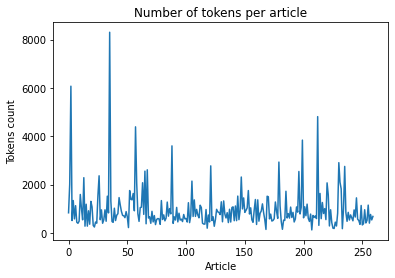

In [ ]:
plt.figure(1)
plt.plot([len(tokens) for tokens in tokens_list])
plt.title('Number of tokens per article')
plt.xlabel('Article')
plt.ylabel('Tokens count')
plt.show()

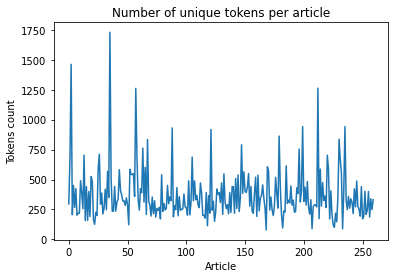

In [ ]:
plt.figure(2)
plt.plot([len(set(tokens)) for tokens in tokens_list])
plt.title('Number of unique tokens per article')
plt.xlabel('Article')
plt.ylabel('Tokens count')
plt.show()

In [ ]:

def label_counts(lbls):
  zeros = lbls.count(0)
  ones = len(lbls) - zeros
  return (zeros, ones)
lbl_counts = list(zip(*map(label_counts, labels_list)))

In [ ]:
avg = lambda li : int(sum(li) / len(li))
zero_avg = avg(lbl_counts[0])
ones_avg = avg(lbl_counts[1])
print(zero_avg, "average number of non propaganda tokens")
print(ones_avg, "average number of propaganda tokens")

864 average number of non propaganda tokens
101 average number of propaganda tokens


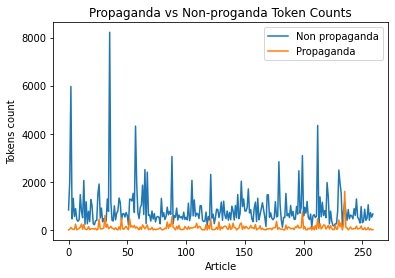

In [ ]:
plt.figure(3)
plt.plot(lbl_counts[0], label="Non propaganda")
plt.plot(lbl_counts[1], label="Propaganda")
plt.title('Propaganda vs Non-proganda Token Counts')
plt.xlabel('Article')
plt.ylabel('Tokens count')
plt.legend()
plt.show()

251275  total number of tokens
16266  total number of unique tokens
6858  tokens that appear only once
[('the', 13939), (',', 11020), ('.', 9854), ('to', 6474), ('of', 6303)]  List of 5 most common tokens


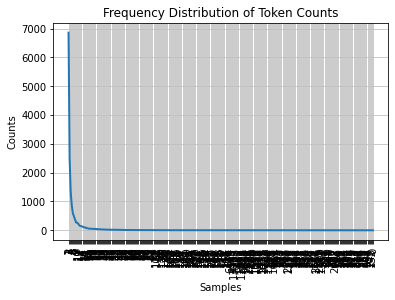

In [ ]:
fdist_counts = nltk.FreqDist([t for li in tokens_list for t in li])
print(fdist_counts.N(), ' total number of tokens')
print(fdist_counts.B(), ' total number of unique tokens')
print(fdist_counts.r_Nr()[1], ' tokens that appear only once')
print(fdist_counts.most_common(5), ' List of 5 most common tokens')
nltk.FreqDist(fdist_counts.r_Nr()).plot(title="Frequency Distribution of Token Counts")

In [ ]:
print("Examples of propaganda sentences:\n")

for t in range(5):
  ind = random.randint(0, num_articles)
  ranges = itertools.groupby(enumerate(labels_list[ind]), key=lambda elt:elt[1])
  positive_ranges = [(next(g)[0], sum(1 for i in g)) for _, g in filter(lambda kv: kv[0] == 1, ranges)]
  positive_ranges = sorted(positive_ranges, key=lambda x: x[1], reverse=True)
  if len(positive_ranges) > 3:
    positive_ranges = positive_ranges[:3]
  for r in positive_ranges:
    start = r[0]
    end = start+r[1]+1
    print(" ".join(tokens_list[ind][start:end]))

Examples of propaganda sentences:

i have no doubt from the information circulated about me and campaign run against me prior to this vote that this was about my jewish identity , and nothing more
why did a bds-led campaign name and shame me for my affiliation with a jewish organization , and call on students to remove me from student government for this reason
if bds is not anti-semitic , why was i barred from participating in student government because of my jewish identity
wilson was accused of exporting weapons without a license , just as if he ’ d shipped his plastic gun to mexico rather than put a digital version of it on the internet
the latter think that removing guns will suddenly force humanity to stop all animosity toward one another , hold hands , and sing kumbaya
gun control would never be the same in an era when anyone can download and print their own firearm with a few clicks
jim comey and jim comey alone
jim comey and jim comey alone
deep state plot
devoted news consume

### Q1: Initial data observations
What are your initial observations of the dataset after you explore the dataset?

**Answer:**

Most articles have 500 - 1000 tokens but there are outliers having upto 8,000 tokens.
Considering only unique tokens, most articles have 250 - 500 unique tokens but there are outliers having over 1500 unique tokens.

On average, only about 100 tokens per article are propaganda while 800 are non-propaganda. However, distribution of propaganda tokens among articles isn't very skewed.

The dataset is dominated by frequent tokens. Even though there are more than 250,000 tokens total, only 16,000 of those are unique and out of those, 6,000 of them appear only once. 

# Model 1: HMM Implementation

---

In this section, you will implement a HMM model for this task. We expect:


1. An implementation of the **Viterbi algorithm** that can be used to infer token-level labels --- propaganda or not propaganda --- for an input document.   This process is commonly referred to as **decoding**.
2. Code for counting and smoothing of labels and words as necessary to support the HMM decoding. (This is pretty much what you already know how to do from project 1.)


The tokenization of documents can be performed with the code we provide above. We suggest you calculate probabilities in a log form.  Bigram Viterbi is $ \mathcal{O}(sm^2)$ where s is the length of the sentence and m is the number of tags. Your implementation should have similar efficiency.

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programmes to detect plagiarism.

In [ ]:
# Evaluate/validate your model here
# you may attach pictures of graphs etc.

start_counts = [0, 0]
label_counts = [0, 0]
token_label_counts = {'unk' : [0,0]}
temp = {}  # maintains tokens with counts < 2
bigram_label_counts = {(0,0) : 0, (0,1) : 0, (1,0) : 0, (1,1) : 0} 


def populate_counts(tokens : List[str], tok_labels : List[int]) -> None:
  for i, token in enumerate(tokens):
    label = tok_labels[i]
    label_counts[label] += 1
    if i == 0:
      start_counts[label] += 1
    
    if token in token_label_counts:
      token_label_counts[token][label] += 1
    else:
      counts = [0, 0]
      store = temp
      if token in temp:
        counts = temp[token]
        store = token_label_counts
        del temp[token]
      counts[label] += 1
      store[token] = counts

    if i+1 < len(tok_labels):
      next_label = tok_labels[i+1]
      bigram_label_counts[(label, next_label)] += 1


def train_hmm_model(tokens_list : List[List[str]],
                    labels_list : List[List[int]]) -> None:
  global start_counts, label_counts, token_label_counts, temp, bigram_label_counts
  start_counts = [0, 0]
  label_counts = [0, 0]
  token_label_counts = {'unk' : [0,0]}
  temp = {} 
  bigram_label_counts = {(0,0) : 0, (0,1) : 0, (1,0) : 0, (1,1) : 0} 
  assert len(tokens_list) == len(labels_list)
  total_num_tokens = 0
  for tokens, labels in zip(tokens_list, labels_list):
    populate_counts(tokens, labels)
    total_num_tokens += len(tokens)
  for tks, cts in temp.items():
    token_label_counts['unk'][0] += cts[0]
    token_label_counts['unk'][1] += cts[1]
  assert start_counts[0] + start_counts[1] == len(tokens_list)
  assert label_counts[0] + label_counts[1] == total_num_tokens
  zeros, ones = 0, 0
  for tkn, cts in token_label_counts.items():
    zeros += cts[0]
    ones += cts[1]
  assert zeros == label_counts[0]
  assert ones == label_counts[1]


In [ ]:
# Your implementation here
# we expect a function or class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below

def start_prob(s):
  k = 0.0001
  total_counts = start_counts[0] + start_counts[1]
  prob = (start_counts[s] + k) / (total_counts + 2*k)
  return math.log(prob)


def transition_prob(s1, s2):
  k = 0.00001
  prob = (bigram_label_counts[(s1,s2)] + k) / (label_counts[s1] + 2*k)
  return math.log(prob)


def emission_prob(token, s):
  k = 0.95
  de = label_counts[s]
  if token in token_label_counts:
    nu = token_label_counts[token][s]
  else:
    nu = token_label_counts['unk'][s]
  prob = (nu + k) / (de + 2*k)
  return math.log(prob)


def gen_labels(tokens : List[str]) -> Tuple[List[int]]:
  vertibi = []
  vertibi.append([start_prob(0) + emission_prob(tokens[0], 0)]) 
  vertibi.append([start_prob(1) + emission_prob(tokens[0], 1)])
  backptrs = [[-1], [-1]]
  num_tokens = len(tokens)
  for i in range(1, num_tokens):
    token = tokens[i]
    for j in range(2):
      best_prob = float("-inf")
      ptr = 0
      for k in range(2):
        curr_prob = vertibi[j][-1] + transition_prob(j, k) + emission_prob(token, k)
        if curr_prob > best_prob:
          best_prob = curr_prob
          ptr = k
      vertibi[j].append(best_prob)
      backptrs[j].append(ptr)

  assert (len(vertibi[0]) == len(vertibi[1]))
  assert (num_tokens == len(vertibi[0]))

  labels = []

  if vertibi[0][num_tokens-1] > vertibi[1][num_tokens-1]:
    labels.append(0)
    ptr = backptrs[0][num_tokens-1]
  else:
    labels.append(1)
    ptr = backptrs[1][num_tokens-1]

  for i in range(num_tokens-2, -1, -1):
    labels.append(ptr)
    ptr = backptrs[ptr][i]
  
  assert ptr == -1
  assert len(labels) == len(tokens)
  return list(reversed(labels))

## Validation Step

1. Create a validation set from the given dataset, i.e. a subset of (~10%) the training dataset that you only use for evaluating the models, not for training.  (You can think of the validation set as a sample test set.)
2. Train your HMM model on the (remainder of the) training set and evaluate it on the validation set. Report **weighted accuracy**, which is explained in the *Notes* section above.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generaion) probabilities. 

In the *Kaggle Submission* section, there is code provided for generating the output file in the form required for Kaggle.  If you find it useful for computing weighted accuracy, you can use it here as well.

In [ ]:
d = int(num_articles * 0.85)
train_tokens_list, val_tokens_list = tokens_list[:d], tokens_list[d:]
train_labels_list, val_labels_list = labels_list[:d], labels_list[d:]

train_hmm_model(train_tokens_list, train_labels_list)

prop_count, non_prop_count = 0, 0
mis_prop, mis_non_prop = 0, 0
for i, tokens in enumerate(val_tokens_list):
  predicted_labels = np.array(gen_labels(tokens))
  true_labels = np.array(val_labels_list[i])
  prop = np.count_nonzero(true_labels == 1)
  prop_count += prop
  non_prop_count += (len(true_labels) - prop)
  diff = true_labels - predicted_labels
  mis_prop += np.count_nonzero(diff == 1)
  mis_non_prop += np.count_nonzero(diff == -1)

print(mis_prop, ' propaganda misclassified out of ', prop_count)
print(mis_non_prop, ' non-propaganda misclassified out of ', non_prop_count)

total_val_labels = prop_count + non_prop_count
prop_wt = (prop_count / total_val_labels) ** -1
non_prop_wt = (non_prop_count / total_val_labels) ** -1
wt_acc = ((prop_wt * (prop_count - mis_prop) + non_prop_wt * (non_prop_count - mis_non_prop)) /
          (prop_wt * prop_count + non_prop_wt * non_prop_count))
print('{0:.4f} accuracy'.format(wt_acc))


3142  propaganda misclassified out of  4780
4731  non-propaganda misclassified out of  27373
0.5849 accuracy




### Q2 : Explan your HMM implementations

Q2.1: Explain here how you implemented HMMs (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:**

We implemented the HMM model from scratch. During training, we use lists to maintain count of labels because the labels themselves are indices that can be used to index into the list in constant time.
However, we maintain the count of tokens in a dictionary to get constant time access since the tokens are strings. The corresponding values are lists of length 2. The first index counts the number of times the token appeared with a '0' label and the second index the '1' label. We use this scheme so that we only store the keys once and to be able to use the labels directly as indices to get the required counts. 
We also use a dictionary to maintain the count of consecutive pair of labels. The keys are tuples of the 4 possible unique pairs of labels and the values are integer counts. 
Using these counts, we implemented functions to caluculate start, transition and emission probabilities. These methods are then called in the function that uses the vertibi algorithm to calculate the most probable sequence of labels. 
The vertibi algorithm uses a 2*N list to maintain score values. 



Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your HMM implementation, why?).

**Answer:**

We converted words appearing less than twice in the training corpus to unknown words. This value was set after looking at the distribution of frequency counts and observing weighted accuracy on the validation set. 
Each function for calculating the probabilities has its own add-k hyperparameter. This is to enable each of them to be tuned separately using the validation set. 

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

We split the data into 85% for training and 15% for validation. We then trained the hmm model on using the training set and then evaluated on the validation set. The model requires a smoothing hyperparameter for each of the probability functions as well as the unknown threshold. The default values were initialized by intuition. Then we experimented with different values to obtain the set of hyperparameters that perfomed best on the validation set. 
We observed that smoothing the start and transition probabilities didn't really affect the model performance so we set them to very small values so that we don't end up with zeros which would cause errors when log is applied. 
After testing different values of k, we found that k=0.95 resulted in the best performance on the validation set. Weighted accuracy improved from 0.49 with the default values to 0.58 after tuning the hyperparameters. 

Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:**

Without smoothing the emission probabilities weighted accuracy was very low because the system misclassified neary all propaganda tokens. This can be attributed to the fact that there are so few propaganda tokens compared to non_propaganda, hence, without smoothing, propaganda tokens are very unlikely.

Q3.3: What is the effect of unknown word handling and smoothing?

**Answer:**

Smoothing improves the weighted accuracy. Although it results in more non-propaganda tokens being misclaffied, less propaganda tokens are misclassified resulting in improved weighted accuracy because propability mass is moved from non-propaganda to propaganda tokens. Unknown word handling also results in improved weighted accuracy because it enables words that don't appear in the training corpus to have non-zero probability.


# Model 2: MEMM Implementation

---


In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same propaganda detection task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 
 
1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such classifier, you need to pick some feature set. The content of the feature set is up to your choice. You should be trying different feature sets, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in *Evaluation* section. 





---
Work flow summary:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)




In [ ]:
! pip install vaderSentiment

In [ ]:
# Your model implementation here
# we expect a function of class, mapping a sequence of tokens to a sequence of labels
# this function or class will be called below
#
# You will need:
# 1. Extract Features
# 2. Train MaxEnt
# 3. To call Viterbi 

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import spacy
from spacy.tokens import Doc
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

nlp = spacy.load("en_core_web_sm")

def extract_features(tokens : List[str], labels : List[int]):
  doc = nlp(" ".join(tokens))
  sentiments = [analyzer.polarity_scores(token) for token in tokens]
  features = []
  true_labels = []
  for i, token in enumerate(tokens):
      label = labels[i]
      end = len(tokens)-1 
      window = {}
      w = 20
      k = -w
      for cur in range(i-w, i+w):
        key1 = 'word'+str(k)
        key2 = 'pos'+str(k)
        key3 = 'tag'+str(k)
        key4 = 'lemma'+str(k)
        key5 = 'sent'+str(k)
        key6 = 'rank'+str(k)
        key7 = 'punct'+str(k)
        key8 = 'ent'+str(k)
        if cur >= 0 and cur <= end:
          window[key1] = tokens[cur]
          window[key4] = doc[cur].lemma_
          window[key2] = doc[cur].pos_
          window[key3] = doc[cur].tag_
          window[key7] = str(doc[cur].is_punct)
        k += 1
      l = max(0, i-w)
      r = min(i+w, end+1)
      window[key5] = analyzer.polarity_scores(" ".join(tokens[l:r]))['compound']
      window.update(sentiments[i])
      
      features.append(window)
      true_labels.append(label)
  return features, true_labels

def features_from_tokens(tokens_list : List[List[str]],
                         labels_list : List[List[int]]):
  features = []
  true_labels = []
  for tokens, labels in zip(tokens_list, labels_list):
    curr_features, curr_labels = extract_features(tokens, labels)
    features += curr_features
    true_labels += curr_labels
  return features, true_labels

train_features, train_labels = features_from_tokens(train_tokens_list, train_labels_list)
val_features, val_labels = features_from_tokens(val_tokens_list, val_labels_list)
print(len(val_features), len(val_labels))
vec = DictVectorizer()
X_train = vec.fit_transform(train_features, train_labels)
X_val = vec.transform(val_features)
clf = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
log_probs = clf.predict_log_proba(X_val)

print(log_probs.shape)

32153 32153
(32153, 2)


In [ ]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)

def gen_labels_lr(log_probs : List[List[float]]) -> List[int]:
  vertibi = []
  vertibi.append([log_probs[0][0]]) #must be log probs
  vertibi.append([log_probs[0][1]])
  backptrs = [[-1], [-1]]
  num_tokens = len(log_probs)
  for i in range(1, num_tokens):
    for j in range(2):
      best_prob = float("-inf")
      ptr = 0
      for k in range(2):
        curr_prob = vertibi[j][-1] + log_probs[i][k]
        if curr_prob > best_prob:
          best_prob = curr_prob
          ptr = k
      vertibi[j].append(best_prob)
      backptrs[j].append(ptr)

  assert (len(vertibi[0]) == len(vertibi[1]))
  assert (num_tokens == len(vertibi[0]))

  labels = []

  if vertibi[0][num_tokens-1] > vertibi[1][num_tokens-1]:
    labels.append(0)
    ptr = backptrs[0][num_tokens-1]
  else:
    labels.append(1)
    ptr = backptrs[1][num_tokens-1]

  for i in range(num_tokens-2, -1, -1):
    labels.append(ptr)
    ptr = backptrs[ptr][i]
  # print(vertibi)
  assert ptr == -1
  assert len(labels) == num_tokens
  return list(reversed(labels))

predicted_labels = np.array(gen_labels_lr(log_probs))
true_labels = np.array(val_labels)
prop_count = np.count_nonzero(true_labels == 1)
non_prop_count = (len(true_labels) - prop_count)
diff = true_labels - predicted_labels
mis_prop = np.count_nonzero(diff == 1)
mis_non_prop = np.count_nonzero(diff == -1)

print(mis_prop, ' propaganda misclassified out of ', prop_count)
print(mis_non_prop, ' non-propaganda misclassified out of ', non_prop_count)

f1_score = f1_score(true_labels, predicted_labels)
print('f1_score', f1_score)

total_val_labels = prop_count + non_prop_count
prop_wt = (prop_count / total_val_labels) ** -1
non_prop_wt = (non_prop_count / total_val_labels) ** -1
wt_acc = ((prop_wt * (prop_count - mis_prop) + non_prop_wt * (non_prop_count - mis_non_prop)) /
          (prop_wt * prop_count + non_prop_wt * non_prop_count))
print('{0:.4f} accuracy'.format(wt_acc))

4232  propaganda misclassified out of  4780
869  non-propaganda misclassified out of  27373
f1_score 0.17685977085686622
0.5414 accuracy


In [ ]:
def gen_test_labels(tokens : List[str])-> List[int]:
  test_features, _ = extract_features(tokens, [0 for i in range(len(tokens))])
  assert len(tokens) == len(test_features)
  X_test = vec.transform(test_features)
  log_probs = clf.predict_log_proba(X_test)
  predicted_labels = gen_labels_lr(log_probs)
  assert len(predicted_labels) == len(tokens)
  return predicted_labels

### Q4: Implementation Details

Q4.1: Explain here how you implemented the MEMM (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**

We used sklearn's logistic regression to train our MEMM model. We wrote code for extracting features and then trained the logistic regression model to obtain the probabilities. We then implemented the vertibi algorithm similar to the previous part except it uses probabilities from logistic regression as a replacement of both transition and emission probabilities.

Q4.2: What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets.

**Answer:**

The most important features were the current word token and words in the surrounding window. This is attributed to the fact that propaganda uses words that are accusatory and are used in a sequence. We experimented with a number of different features including the label of preceding tokens, pos_tags in the frame window, lemma of the words, sentiments, entities, punctuations and word lengths


### Q5: Results Analysis

Q5.1: Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

We evaluated our model using different feature sets on the validation set, that is the same validation set used for hmm. We also tried varying the size of the window around which we collected our features. We observed the accuracy improving as the window became larger although the training time also increased. Accuracy also tended to increase as we added more features, although some features would cause a drop in performace such as length of words. 

Q5.2: An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why? 

**Answer:**

The words in the feature window are the most helpful because they are a strong signal for propaganda. The sentiment of the token and surrounding tokens also proved to be very useful because propaganda tends to be associated with negative words compared to non-propaganda. The parts-of-speech tags also proved to be quite useful because the tags help resolve ambigous words. The lemma was also useful because it helped associate words with the same root. The errors consisted of mostly misclassified propaganda tokens than misclassified non-propaganda because the dataset consisted of mostly non-propaganda tokens which resulted in higher probabilities for those states. 

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:**

The system worked well on non-propaganda tokens and failed on propaganda tokens classification because there were much fewer propaganda tokens which made it harder for the model to fit accurately.


#Comparing HMMs and MEMMs

---


### Q6:


Compare here your results for your HMM and the MEMM. Which of them performs better? 

**Answer:**

After tuning, The HMM model achieves a slightly higher weighted accuracy compared to MEMM

###Q7: Error Analysis
Q7.1: Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not?

**Answer:**

The HMM misclassifies more non-propaganda tokens and less propaganda tokens compared to MEMM. This is because we apply quite a lot of smoothing to the HMM emission probabilities which transfers the probability mass from non-propaganda labels to propaganda labels.

Q7.2: What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe?

**Answer:**

The MEMM misclassifies a lot more propaganda tokens than non-propaganda tokens because the non-propaganda tokens have a lot higher probabilities as a result of dominating the dataset. 




# Kaggle Submission 
---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to Kaggle at https://www.kaggle.com/t/8a8030baefcc4d91b715f114353dba38. Note, you **need** to use our tokenizer as the labels on Kaggle corresponds to these. Below, we provide a script that submits a random guess/all ones or all zeroes in the correct format. Note that you only need to provide a function which takes as input a sequence of tokens, and outputs a sequence of labels (in the form of integers  in {0,1}, 1 corresponding to propaganda). As a scoring metric on Kaggle, we use **weighted accuracy**, described in the *Notes* section towards the beginning of the notebook.


In [ ]:
import random
from typing import Callable


def submission_to_csv(binary_class : List[List[int]], fname : str):
  # writes submission to CSV
  new_binary = []
  for classes in binary_class:
    new_binary += classes
  with open(fname, 'w') as file:
    file.write('id,category\n')
    for i, line in enumerate(new_binary):
      file.write('{},{}\n'.format(i,line))


def random_predictor(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(random.randint(0,1))
  return output

def always_one(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(1)
  return output

def always_zero(article_tokens : List[str]) -> List[int]:
  # random predictor
  output = []
  for _ in range(len(article_tokens)):
    output.append(0)
  return output


def generate_submission(predictor: Callable[[List[str]], List[int]], fname : str, test_path : str):
  # generate a submission with random guesses
  sample_submission = []
  articles = os.listdir(test_path)
  total, fail, targets, test_articles = 0,0, [], []
  for article in sorted(articles):
    article_file = os.path.join(test_path, article)
    art_toks = tokenize_article(article_file)
    curr_article = predictor(art_toks)
    assert len(curr_article) == len(art_toks)
    sample_submission.append(curr_article)
  submission_to_csv(sample_submission, fname)


generate_submission(random_predictor, "random_submission.csv", test_path)
generate_submission(always_one, "ones_submission.csv", test_path)
generate_submission(always_zero, "zeros_submission.csv", test_path)
generate_submission(gen_labels, "hmm_submission.csv", test_path)
generate_submission(gen_test_labels, "memm_submission.csv", test_path)


---
### Q8: Competition Score

Include here your **team name** and the **screenshot** of your best score from Kaggle.

**Answer:**

Team name: lkn28_foo6

Best score: 0.55283

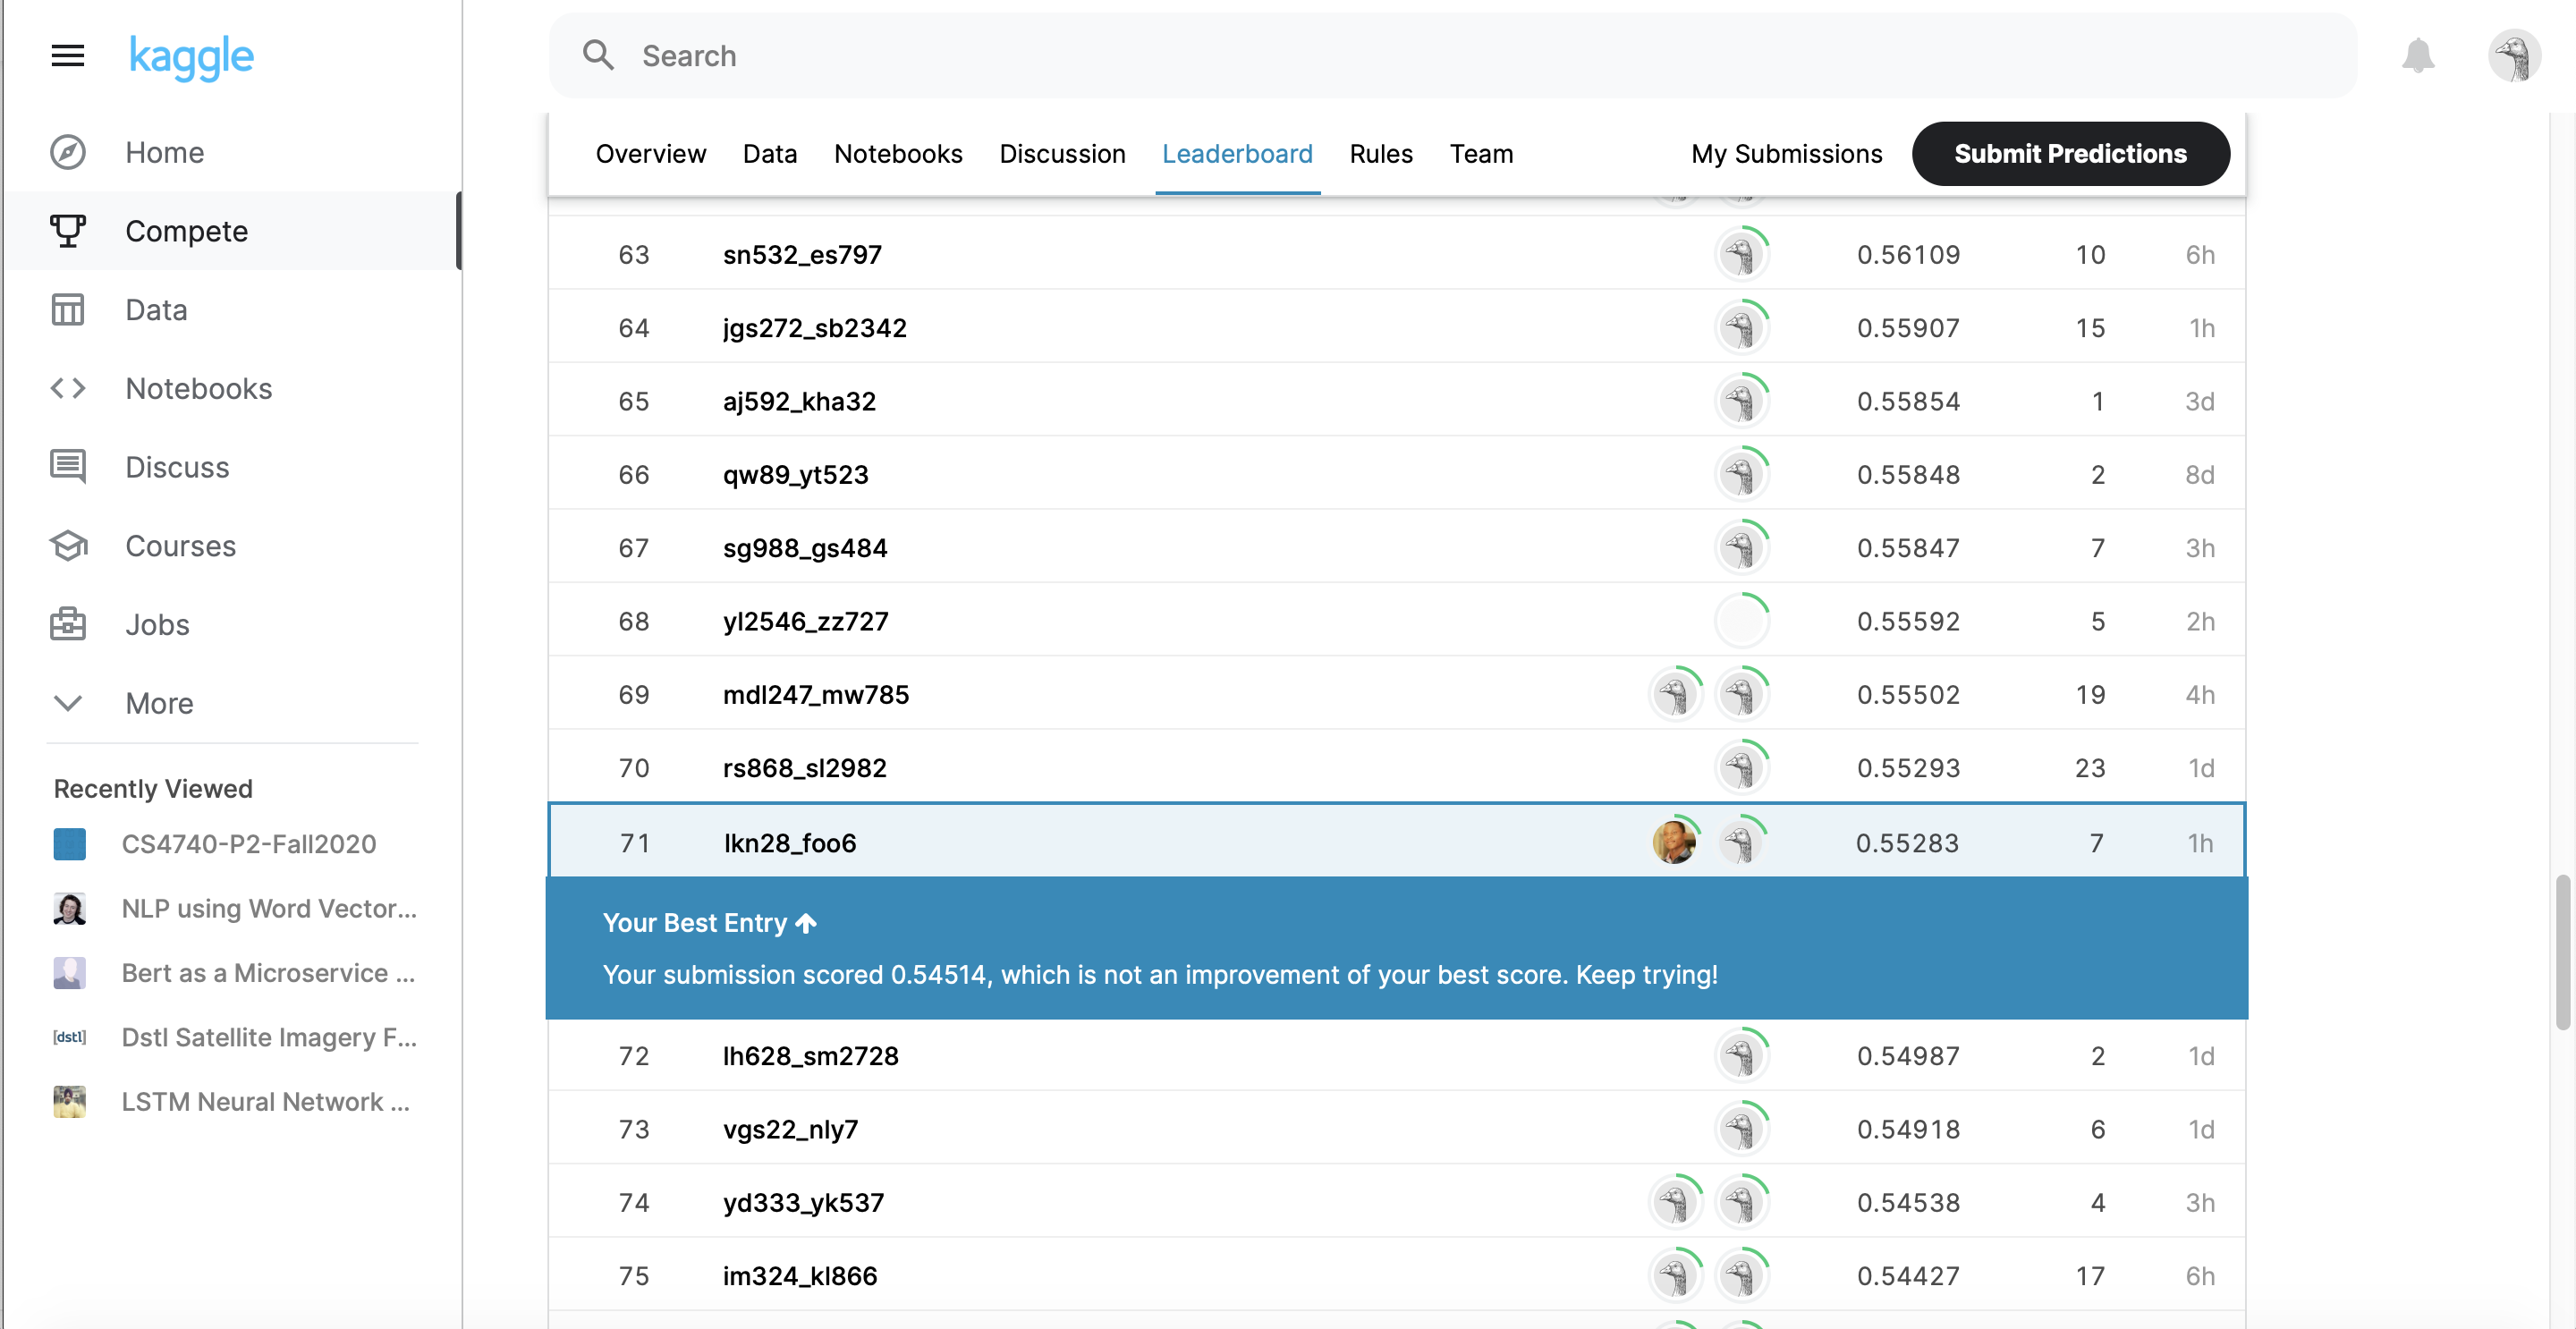

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%%capture
# the red text is a placeholder! Change it to your directory structure!
!cp 'drive/My Drive/CS5740/P2/4740_FA20_p2_lkn28_foo6.ipynb' ./ 

In [ ]:
# the red text is a placeholder! Change it to the name of this notebook!
!jupyter nbconvert --to PDF "4740_FA20_p2_lkn28_foo6.ipynb"

[NbConvertApp] Converting notebook 4740_FA20_p2_lkn28_foo6.ipynb to PDF
[NbConvertApp] Support files will be in 4740_FA20_p2_lkn28_foo6_files/
[NbConvertApp] Making directory ./4740_FA20_p2_lkn28_foo6_files
[NbConvertApp] Making directory ./4740_FA20_p2_lkn28_foo6_files
[NbConvertApp] Making directory ./4740_FA20_p2_lkn28_foo6_files
[NbConvertApp] Making directory ./4740_FA20_p2_lkn28_foo6_files
[NbConvertApp] Writing 706226 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Stan

#Appendix
---

### Tentative grading guideline

- (5 pts) Dataset exploration.
- (20 pts) Design and implementation of the HMM model. Specifically, calculations of emission/transition probability, smoothing, handling of unknown words.
- (20 pts) Design and implementation of the MEMM, as well as the feature set and how the feature extraction is done.
- (20 pts) Experiment design and methodology. Investigations into feature sets and unknown word handling/smoothing.
- (20 pts) Error analysis and comparison of **HMM** model with the **MEMM**. 
- (10 pts) Report: organization, clarity and including the **corresponding pieces of code for the implementations**.
- (5 pts) **Submission to Kaggle**. In the report, you should add a screenshot of your team’s performance on kaggle leaderboard.

